In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# =========================
# CONFIG
# =========================
DATASET_PATH = r"C:\Users\LENOVO\Projects\Jelly_Fish_Projects\Jelly_fish_Dataset"
IMG_SIZE = 224
TEST_SIZE = 0.2

# =========================
# LOAD DATA
# =========================
X = []
y = []

class_names = os.listdir(DATASET_PATH)
print("Classes found:", class_names)

for class_name in class_names:
    class_path = os.path.join(DATASET_PATH, class_name)

    if not os.path.isdir(class_path):
        continue

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        try:
            img = cv2.imread(img_path)

            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            X.append(img)
            y.append(class_name)

        except Exception as e:
            print(f"Error loading {img_path}")

# =========================
# CONVERT TO NUMPY
# =========================
X = np.array(X, dtype="float32") / 255.0
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

# =========================
# LABEL ENCODING
# =========================
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

print("Encoded classes:", label_encoder.classes_)

# =========================
# TRAIN TEST SPLIT
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_categorical,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y_encoded
)

print("Train data:", X_train.shape, y_train.shape)
print("Test data :", X_test.shape, y_test.shape)


Classes found: ['.ipynb_checkpoints', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish', 'Moon_jellyfish']
X shape: (900, 224, 224, 3)
y shape: (900,)
Encoded classes: ['Moon_jellyfish' 'barrel_jellyfish' 'blue_jellyfish' 'compass_jellyfish'
 'lions_mane_jellyfish' 'mauve_stinger_jellyfish']
Train data: (720, 224, 224, 3) (720, 6)
Test data : (180, 224, 224, 3) (180, 6)


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze pretrained layers
base_model.trainable = False

In [4]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 jellyfish classes
])

In [5]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2597 - loss: 1.8768 - val_accuracy: 0.5278 - val_loss: 1.4624
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 862ms/step - accuracy: 0.3931 - loss: 1.5371 - val_accuracy: 0.6167 - val_loss: 1.2512
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 920ms/step - accuracy: 0.5625 - loss: 1.2665 - val_accuracy: 0.6889 - val_loss: 1.1005
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 889ms/step - accuracy: 0.5986 - loss: 1.1681 - val_accuracy: 0.7222 - val_loss: 0.9843
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6347 - loss: 1.0393 - val_accuracy: 0.7889 - val_loss: 0.8809
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6514 - loss: 0.9608 - val_accuracy: 0.7944 - val_loss: 0.8074
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7333 - loss: 0.8544 - val_accuracy: 0.8167 - val_loss: 0.7436
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 888ms/step - accuracy: 0.7389 - loss: 0.7905 - val_accuracy: 0.8167

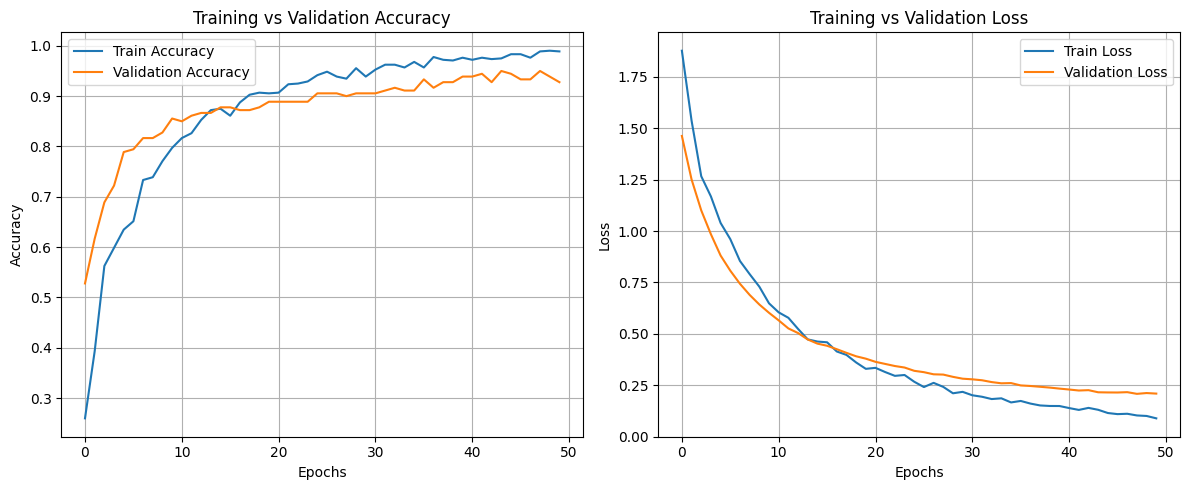

In [8]:
import matplotlib.pyplot as plt

# =========================
# ACCURACY & LOSS PLOTS
# =========================
plt.figure(figsize=(12, 5))

# ---- Accuracy ----
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

# ---- Loss ----
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


array([0, 2, 3, 4, 0, 1, 0, 5, 1, 3, 1, 1, 3, 0, 2, 1, 5, 2, 2, 5, 1, 5,
       3, 3, 2, 4, 3, 2, 5, 2, 2, 4, 4, 3, 2, 1, 2, 1, 2, 2, 5, 5, 5, 4,
       1, 0, 0, 2, 3, 1, 2, 1, 5, 2, 1, 0, 4, 5, 0, 4, 1, 0, 5, 5, 3, 3,
       3, 1, 0, 3, 1, 5, 1, 5, 4, 3, 2, 4, 5, 0, 4, 2, 3, 0, 4, 0, 2, 2,
       3, 1, 1, 0, 5, 5, 3, 2, 3, 4, 4, 3, 0, 3, 4, 4, 5, 1, 4, 3, 0, 2,
       5, 5, 4, 5, 0, 1, 3, 0, 2, 1, 1, 2, 5, 2, 3, 4, 0, 0, 0, 0, 2, 5,
       4, 5, 0, 4, 0, 4, 3, 1, 0, 3, 2, 0, 0, 5, 2, 4, 1, 3, 2, 5, 3, 0,
       1, 4, 3, 0, 5, 0, 1, 5, 0, 3, 4, 1, 4, 5, 0, 4, 3, 0, 0, 1, 3, 0,
       3, 4, 4, 4])

In [ ]:
# Save model in modern Keras format
model.save("jellyfish_mobilenetv2.keras")
import pickle

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)